In [1]:
import torch
from transformers import AutoTokenizer, DataCollatorWithPadding, AdamW, get_linear_schedule_with_warmup
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from datasets import load_dataset

import torch.nn as nn
from transformers import BertTokenizer, RobertaModel

c:\Users\youss\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = load_dataset("Fatima0923/Automated-Personality-Prediction")
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'agreeableness', 'openness', 'conscientiousness', 'extraversion', 'neuroticism'],
        num_rows: 16047
    })
    validation: Dataset({
        features: ['text', 'agreeableness', 'openness', 'conscientiousness', 'extraversion', 'neuroticism'],
        num_rows: 2415
    })
    test: Dataset({
        features: ['text', 'agreeableness', 'openness', 'conscientiousness', 'extraversion', 'neuroticism'],
        num_rows: 2415
    })
})

In [3]:
dataset['train'][:2]

{'text': ['his name was kim kimble originally wow thats some messed up parents',
  'theyre better than the normal posts on ryugioh id rather have them then the same topic posted multiple times in the week after the banlist'],
 'agreeableness': [9.0, 50.0],
 'openness': [61.0, 85.0],
 'conscientiousness': [13.0, 50.0],
 'extraversion': [4.0, 85.0],
 'neuroticism': [72.0, 50.0]}

In [4]:
train_text = dataset['train']['text']
val_text = dataset['validation']['text']
test_text = dataset['test']['text']
train_text[:3]

['his name was kim kimble originally wow thats some messed up parents',
 'theyre better than the normal posts on ryugioh id rather have them then the same topic posted multiple times in the week after the banlist',
 'how the fuck does this even happen hi youre cute you too ive had a crush on you for awhile um i uh inserts finger in butthole']

In [5]:
label1 = dataset['train']['agreeableness']
label2 = dataset['train']['openness']
label3 = dataset['train']['conscientiousness']
label4 = dataset['train']['extraversion']
label5 = dataset['train']['neuroticism']
train_labels = [[a, b, c, d, e] for a, b, c, d, e in zip(label1, label2, label3, label4, label5)]
# the labels range from 0-100 so we need to normalize them to 0-1
train_labels = torch.tensor(train_labels)/100


label1 =dataset['validation']['agreeableness']
label2 = dataset['validation']['openness']
label3 = dataset['validation']['conscientiousness']
label4 = dataset['validation']['extraversion']
label5 = dataset['validation']['neuroticism']
val_labels = [[a, b, c, d, e] for a, b, c, d, e in zip(label1, label2, label3, label4, label5)]
val_labels = torch.tensor(val_labels)/100

label1 = dataset['test']['agreeableness']
label2 = dataset['test']['openness']
label3 = dataset['test']['conscientiousness']
label4 = dataset['test']['extraversion']
label5 = dataset['test']['neuroticism']
test_labels = [[a, b, c, d, e] for a, b, c, d, e in zip(label1, label2, label3, label4, label5)]
test_labels = torch.tensor(test_labels)/100


In [6]:
import re
import string
from bs4 import BeautifulSoup
import nltk
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import spacy

In [7]:
def clean_html(html):

    # parse html content
    soup = BeautifulSoup(html, "html.parser")

    for data in soup(['style', 'script', 'code', 'a']):
        # Remove tags
        data.decompose()

    # return data by retrieving the tag content
    return ' '.join(soup.stripped_strings)

# Load spacy
nlp = spacy.load('en_core_web_sm')

def clean_string(text, stem="None"):

    final_string = ""

    # Make lower
    text = text.lower()

    text = re.sub(r'\n', '', text)

    # Remove punctuation
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)

    # Remove stop words
    text = text.split()
    useless_words = nltk.corpus.stopwords.words("english")
    useless_words = useless_words + ['hi', 'im']

    text_filtered = [word for word in text if not word in useless_words]

    # Remove numbers
    text_filtered = [re.sub(r'\w*\d\w*', '', w) for w in text_filtered]

    # Stem or Lemmatize
    if stem == 'Stem':
        stemmer = PorterStemmer() 
        text_stemmed = [stemmer.stem(y) for y in text_filtered]
    elif stem == 'Lem':
        lem = WordNetLemmatizer()
        text_stemmed = [lem.lemmatize(y) for y in text_filtered]
    elif stem == 'Spacy':
        text_filtered = nlp(' '.join(text_filtered))
        text_stemmed = [y.lemma_ for y in text_filtered]
    else:
        text_stemmed = text_filtered

    final_string = ' '.join(text_stemmed)

    return final_string

In [8]:
train_text = [clean_string(text, "Spacy") for text in train_text]
val_text = [clean_string(text, "Spacy") for text in val_text]
test_text = [clean_string(text, "Spacy") for text in test_text]

In [9]:
import torch.nn as nn

# Bert Model transformer with a sequence regression head on top (a linear
# layer on top of the pooled output).
class RobertaForSequenceRegression(nn.Module):
  def __init__(self, bert_pretrained_model_name, output_size):
    super(RobertaForSequenceRegression, self).__init__()
    self.roberta = RobertaModel.from_pretrained(bert_pretrained_model_name,
                                          output_attentions = False,
                                          output_hidden_states = False)
    self.out = nn.Linear(self.roberta.config.hidden_size, output_size)
    
  def forward(self, input_sentence, input_mask):
    last_hidden_states = self.roberta(input_sentence, attention_mask=input_mask)[1]
    # pooler_output = self.roberta(input_sentence, attention_mask=input_mask).pooler_output
    output = self.out(last_hidden_states)
    return output

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

checkpoint = "FacebookAI/roberta-base"
model = RobertaForSequenceRegression(checkpoint, output_size=5)

# freeze some layers (top | middle | bottom):
# bottom = range(2, 12)
# middle = list(range(0,5))+list(range(7,12))
# top = range(0, 10)

# layersToFreeze = top
# for i in layersToFreeze:
#   print(i)
#   for param in model.bert.encoder.layer[i].parameters():
#     param.requires_grad = False

# Tell pytorch to run this model on the GPU
#model.to(device)

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
            self.texts = texts
            self.labels = labels
            self.tokenizer = tokenizer
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        if len(text) >= 512:
            encoding = self.tokenizer(text, return_tensors='pt', truncation=True, max_length = 512, padding='max_length')
        else:
            encoding = self.tokenizer(text, return_tensors='pt', truncation=True)
        return {'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten(), 'labels': torch.tensor(label)}

In [11]:
batch_size = 4

In [12]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

train_dataset = TextClassificationDataset(train_text, train_labels, tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=data_collator)

val_dataset = TextClassificationDataset(val_text, val_labels, tokenizer)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=data_collator)

test_dataset = TextClassificationDataset(test_text, test_labels, tokenizer)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=data_collator)

In [13]:
batch = next(iter(train_dataloader))
{k: v.shape for k, v in batch.items()}
b_input_ids = batch['input_ids']
b_input_mask = batch['attention_mask']
b_labels = batch['labels']

model(b_input_ids, b_input_mask)

C:\Users\youss\AppData\Local\Temp\ipykernel_13976\86404554.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten(), 'labels': torch.tensor(label)}


tensor([[ 0.0191,  0.0324, -0.0294,  0.1250, -0.1512],
        [ 0.0221,  0.0296, -0.0263,  0.1346, -0.1641],
        [ 0.0221,  0.0442, -0.0431,  0.1259, -0.1536],
        [ 0.0202,  0.0446, -0.0392,  0.1202, -0.1606]],
       grad_fn=<AddmmBackward0>)

In [14]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [15]:
model.to(device)

RobertaForSequenceRegression(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (La

In [16]:
import torch.optim as optim

epochs = 5

optimizer = optim.Adam(model.parameters(), lr=1e-4)
total_steps = len(train_dataloader) * epochs
lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0.1 * total_steps, num_training_steps = total_steps)

criterion = torch.nn.MSELoss()

best_val_loss = float('inf')
epochs_without_improvement = 0
early_stopping_patience = 3

training_stats = []

total_t0 = time.time()

for epoch_i in range(0, epochs):
  # ========================================
  #               Training
  # ========================================
      
  print("")
  print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
  print('Training...')

  t0 = time.time()

  total_train_loss = 0

  model.train()

  # For each batch of training data...
  for step, batch in enumerate(train_dataloader):
    
    # Progress update every 40 batches.
    if step % 40 == 0 and not step == 0:
      elapsed = format_time(time.time() - t0)            
      print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

    b_input_ids = batch['input_ids'].to(device)
    b_input_mask = batch['attention_mask'].to(device)
    b_labels = batch['labels'].to(device)

    # zero gradients
    optimizer.zero_grad()

    # Perform a forward pass (evaluate the model on this training batch).
    output = model(b_input_ids, b_input_mask)

    # loss
    loss = criterion(output, b_labels)
      
    total_train_loss += loss.item()

    loss.backward()
    optimizer.step()
    lr_scheduler.step()

  # Calculate the average loss over all of the batches.
  avg_train_loss = total_train_loss / len(train_dataloader)

  # Measure how long this epoch took.
  training_time = format_time(time.time() - t0)

  print("")
  print("  Average training loss: {0:.2f}".format(avg_train_loss))
  print("  Training epcoh took: {:}".format(training_time))
  
  # ========================================
  #               Validation
  # ========================================
  # After the completion of each training epoch, measure our performance on
  # our validation set.

  print("")
  print("Running Validation...")

  t0 = time.time()

  model.eval()

  # Tracking variables 
  total_eval_accuracy = 0
  total_eval_loss = 0
  nb_eval_steps = 0

  # Evaluate data for one epoch
  for batch in val_dataloader:

     
    b_input_ids = batch['input_ids'].to(device)
    b_input_mask = batch['attention_mask'].to(device)
    b_labels = batch['labels'].to(device)

    
    with torch.no_grad():
      
      # Perform a forward pass
      output = model(b_input_ids, b_input_mask)

    # loss
    loss = criterion(output.view(-1), b_labels.view(-1))

    # Accumulate the development loss.
    total_eval_loss += loss.item()

  # Calculate the average loss over all of the batches.
  avg_val_loss = total_eval_loss / len(val_dataloader)

  # Measure how long the development run took.
  validation_time = format_time(time.time() - t0)
    
  if avg_val_loss < best_val_loss:
    best_val_loss = avg_val_loss
    epochs_without_improvement = 0
    print("Saving model...")
    torch.save(model.state_dict(), "C:/Users/youss/Desktop/MATERIAL/semester VIII/models/IMPORTANT REGRESSORS/roberta pandora/roberta-pandora-model.pth")
  else:
    epochs_without_improvement += 1
    if epochs_without_improvement >= early_stopping_patience:
      print(f'Early stopping triggered after {epoch_i} epochs without improvement.')
      break

  print("  Validation Loss: {0:.2f}".format(avg_val_loss))
  print("  Validation took: {:}".format(validation_time))

  # Record all statistics from this epoch.
  training_stats.append(
      {
          'epoch': epoch_i + 1,
          'Training Loss': avg_train_loss,
          'Training Time': training_time,
          'Valid. Loss': avg_val_loss,
          'Validation Time': validation_time
      })
  
print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training...


C:\Users\youss\AppData\Local\Temp\ipykernel_13976\86404554.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten(), 'labels': torch.tensor(label)}


  Batch    40  of  4,012.    Elapsed: 0:00:06.
  Batch    80  of  4,012.    Elapsed: 0:00:14.
  Batch   120  of  4,012.    Elapsed: 0:00:21.
  Batch   160  of  4,012.    Elapsed: 0:00:29.
  Batch   200  of  4,012.    Elapsed: 0:00:36.
  Batch   240  of  4,012.    Elapsed: 0:00:43.
  Batch   280  of  4,012.    Elapsed: 0:00:49.
  Batch   320  of  4,012.    Elapsed: 0:00:57.
  Batch   360  of  4,012.    Elapsed: 0:01:03.
  Batch   400  of  4,012.    Elapsed: 0:01:10.
  Batch   440  of  4,012.    Elapsed: 0:01:16.
  Batch   480  of  4,012.    Elapsed: 0:01:24.
  Batch   520  of  4,012.    Elapsed: 0:01:32.
  Batch   560  of  4,012.    Elapsed: 0:01:41.
  Batch   600  of  4,012.    Elapsed: 0:01:47.
  Batch   640  of  4,012.    Elapsed: 0:01:52.
  Batch   680  of  4,012.    Elapsed: 0:01:59.
  Batch   720  of  4,012.    Elapsed: 0:02:07.
  Batch   760  of  4,012.    Elapsed: 0:02:13.
  Batch   800  of  4,012.    Elapsed: 0:02:20.
  Batch   840  of  4,012.    Elapsed: 0:02:26.
  Batch   880

In [17]:
import pandas as pd

# Display floats with three decimal places.
#pd.set_option('precision', 4)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Display the table.
df_stats

,Training Loss,Training Time,Valid. Loss,Validation Time
epoch,,,,
1,0.083938,0:11:42,0.080704,0:00:40
2,0.078803,0:11:41,0.079507,0:00:40
3,0.078381,0:11:33,0.079507,0:00:40
4,0.077948,0:11:35,0.078914,0:00:39
5,0.077493,0:11:34,0.078884,0:00:39


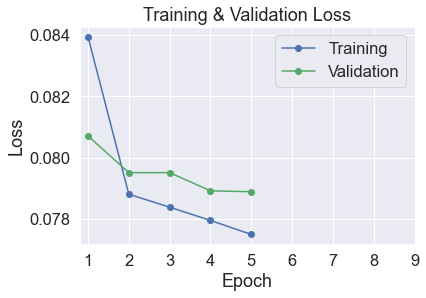

In [18]:
import matplotlib.pyplot as plt
# % matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9])

plt.show()

In [19]:
# Prediction on test set

print('Predicting values for {:,} test sentences...'.format(len(test_dataloader.dataset)))

# Put model in evaluation mode
model.eval()

# Tracking variables
total_test_loss = 0

# Predict 
for batch in test_dataloader:

  # Add batch to GPU
  b_input_ids = batch['input_ids'].to(device)
  b_input_mask = batch['attention_mask'].to(device)
  b_labels = batch['labels'].to(device)
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
    
    # Perform a forward pass
    output = model(b_input_ids, b_input_mask)

  # loss
  loss = criterion(output.view(-1), b_labels.view(-1))

  # Accumulate the development loss.
  total_test_loss += loss.item()

# Calculate the average loss over all of the batches.
avg_test_loss = total_test_loss / len(test_dataloader)

print(avg_test_loss)
print('    DONE.')

Predicting values for 2,415 test sentences...


C:\Users\youss\AppData\Local\Temp\ipykernel_13976\86404554.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten(), 'labels': torch.tensor(label)}


0.07737786523899101
    DONE.


In [20]:
def predict(input):
    tokenizer = AutoTokenizer.from_pretrained(checkpoint)
    encoded_input = tokenizer(input, padding=True, truncation=True, return_tensors='pt')
    model.to('cpu')
    output = model(encoded_input['input_ids'], encoded_input['attention_mask'])
    return output

In [21]:
predict("I can understand about having millions of dollars. There's meaningful freedom that comes with that, but once you get much beyond that I have to tell you, it's the same hamburger.")

tensor([[0.3939, 0.6891, 0.3256, 0.3559, 0.4725]], grad_fn=<AddmmBackward0>)

In [23]:
torch.save(model.state_dict(), "C:/Users/youss/Desktop/MATERIAL/semester VIII/models/roberta_clean_pandora.pth")